In [2]:
from dsoclasses.rinex.doris.rinex import DorisRinex
from os.path import join

# set the filename ...
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")

# construct the instance ...
rnx = DorisRinex(drinex)

## What is the time scale of DORIS (RINEX files) ?

In [3]:
print(f'RINEX reported time system is \"{rnx.time_sys}\"')

RINEX reported time system is "DOR"


Time tags in the RINEX file are reported in 'DORIS' time scale, which is aligned to TAI. Hence, in practice, we consider the RINEX tags to be in (a realization of) TAI.

## What are the nominal DORIS frequencies ?

DORIS transmits on two fundamental frequencies:
 - S1 at 2036.25 MHz ($\approx 15$cm), and
 - U2 at 401.25 ($\approx 75$cm) MHz

Beacon frequencies can be different than the nomial and depend on a "shift factor" $k$, reported in the RINEX file(s).
```text
D37  TLSB TOULOUSE                      10003S005  4   0    STATION REFERENCE   
D38  GR4B GRASSE                        10002S019  4 -15    STATION REFERENCE   
D39  BETB BETIO                         50305S001  3   0    STATION REFERENCE   
D40  NOXC NOUMEA                        92701S005  4   0    STATION REFERENCE   
D41  OWFC OWENGA                        50253S002  4   0    STATION REFERENCE   
D42  ASEB ASCENSION                     30602S005  3   0    STATION REFERENCE   
D43  TSTC TEST-FERMAT                   10003S006  4 -22    STATION REFERENCE 
```

To compute a beacon's nominal frequency, we use the formulae:
$$
    S1(k) = 543 \times USO_{F0} \times 0.75e0 + 543 \times USO_{F0} \times 87 \times k / (5 \times 2^26)
$$
and
$$
    U2(k) = 107 \times USO_{F0} \times 0.75 + 107 \times USO_{F0} \times 87 \times k / (5 \times 2^26)
$$
where $USO_{F0} = 5\times 10^6$; note that for $k=0$ the above results in the fundamental frequencies S1 and U2.

The above computation can be performed by loading:
```python
from dsoclasses.doris.algorithms import beacon_nominal_frequency
s1,u2 = beacon_nominal_frequency(k)
```

Given the RINEX above, what would the transmitted frequencies be for TLSB, GR4B and TSTC ?

In [4]:
from dsoclasses.doris.algorithms import beacon_nominal_frequency

s1,u2 = beacon_nominal_frequency(0)
print(f'TLSB nominal frequencies: {s1*1e-6:.2f} and {u2*1e-6:.2f} MHz')
s1,u2 = beacon_nominal_frequency(-15)
print(f'GR4B nominal frequencies: {s1*1e-6:.2f} and {u2*1e-6:.2f} MHz')
s1,u2 = beacon_nominal_frequency(-22)
print(f'TSTC nominal frequencies: {s1*1e-6:.2f} and {u2*1e-6:.2f} MHz')

TLSB nominal frequencies: 2036.25 and 401.25 MHz
GR4B nominal frequencies: 2036.24 and 401.25 MHz
TSTC nominal frequencies: 2036.23 and 401.25 MHz


## What does each beacon contribute to the observations ?

Let's extract e.g. C1 observations that are performed w.r.t the beacon DIOB:

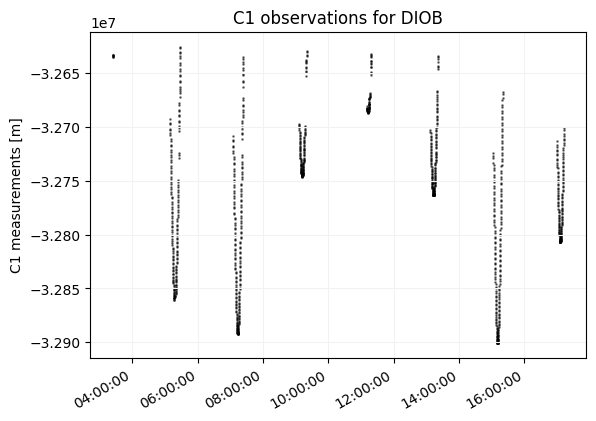

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from dsoclasses.time.pyattotime import at2pt

# get the internal id of the 'DIOB' beacon:
site_id = rnx.name2id('DIOB')

# store measurements here (time, C1)
t = []; C1 = [];

# only consider one day of measurements, so we can have a clearer view
t0 = rnx.time_first_obs

# for every block in RINEX ...
for block in rnx:
    # stop if we reached next day
    if (block.t()-t0).total_seconds() > 86400: break
    # for every beacon in the (current) data block ...
    for beacon, data in block:
        # match the site
        if beacon == site_id:
            # got DIOB! store the data
            t.append(block.t())
            C1.append(data['C1']['value'])

# plot results
plt.scatter([at2pt(ti) for ti in t], C1, color='black', alpha=0.5, s=.8)
plt.grid(color='0.95')
plt.ylabel("C1 measurements [m]")
plt.title("C1 observations for DIOB")
# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()
plt.show()

## How does a site 'see' the passing satellite(s) ?

To see how a DORIS beacon observes a satellite, we can create a skyplot.

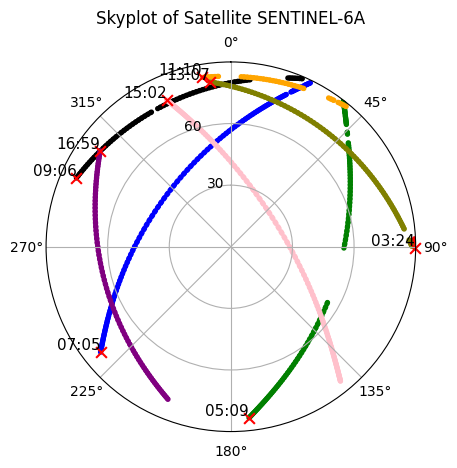

In [12]:
from dsoclasses.sinex import sinex
from dsoclasses.geodesy import transformations
from dsoclasses.orbits.interpolator import Sp3Interpolator
from os.path import join
import datetime

# we need an sp3/interpolator to get satellite position
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
intrp = Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')

# get the internal id of the 'DIOB' beacon:
site_id = rnx.name2id('DIOB')

# get coordinates for the beacon from a dpod file; store into a numpy array
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
result = sinex.extract_sinex_coordinates(dpod, ['DIOB'], rnx.time_first_obs, True, dpod_freq_corr)
diob_xyz = np.array([result['DIOB']['X'], result['DIOB']['Y'], result['DIOB']['Z']])

# R: rotation matrix from cartesian to topocentric, centered on DIOB
lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

# We seem to have several passes over the beacon, each one should be plotted with a different color.
c=['red','green','blue','black','orange', 'olive', 'pink', 'purple', 'brown', 'gray']

# data to plot (different colors for each pass)
azs = []; els = []; colors = [];

# coordinates and time of new entries/passes
entries_az = []; entries_el = []; entries_t = [];

# current color index
color_idx = -1
last_epoch = datetime.datetime.min

# for every block in RINEX ...
for block in rnx:
    # stop if we reached next day
    if (block.t()-rnx.time_first_obs).total_seconds() > 86400: break
    # for every beacon in the (current) data block ...
    for beacon, data in block:
        # match the site
        if beacon == site_id:         
            # got DIOB; get satellite position
            x, y, z, _ = intrp.sat_at('L40', block.t())
            # beacon to satellite vector
            dr = np.array([x, y, z]) - diob_xyz
            # get topocentric coordinates
            enu = R @ dr
            # compute range, azimouth and elevation
            r  = np.linalg.norm(enu)
            az = np.arctan2(enu[0], enu[1])
            el = np.arcsin(enu[2] / r)
            # append new point in spherical coordinates, azimout and elevation
            azs.append(az)
            els.append(90e0 - np.degrees(el))
            # if we are at a new pass, change color and mark as entry point
            if (at2pt(block.t())-last_epoch).total_seconds()>3600:
                color_idx += 1
                entries_az.append(az)
                entries_el.append(90e0 - np.degrees(el))
                entries_t.append(at2pt(block.t()))
            colors.append(c[color_idx])
            last_epoch = at2pt(block.t())

# Create the skyplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# position markers
ax.scatter(azs, els, c=colors, s=8)
# mark entry points with 'x'
ax.scatter(entries_az, entries_el, marker='x', c='red', s=60, clip_on=False)
# time of entry
for i in range(len(entries_t)):
    ax.text(entries_az[i], entries_el[i], entries_t[i].strftime("%H:%M"),
    fontsize=11, ha='right', va='bottom', clip_on=False)
ax.set_rmax(90)
ax.set_rticks([30, 60])
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# Rotate the angle axis by -90 degrees (make 0 degrees point up)
ax.set_theta_zero_location('N')  # Set 0 to the top (North)
ax.set_theta_direction(-1)  # Make the angles increase clockwise

ax.set_title(f"Skyplot of Satellite {rnx.sat_name}", va='bottom')
plt.show()